In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-09 14:07:16--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py.1’

models.py.1         100%[===================>]  14.71K  --.-KB/s    in 0s      

2023-11-09 14:07:17 (119 MB/s) - ‘models.py.1’ saved [15061/15061]

--2023-11-09 14:07:17--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6436 (6.3K) [text/plain]
S

In [ ]:
from utils import vision
from utils import utils
from utils import losses

In [ ]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (224, 224),
    'INPUT_SHAPE': (224, 224, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "autoencoder_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "autoencoder_model/BD67_dataset/images",
}

In [ ]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
TFRECORD_TRAIN_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images.tfrecords'
TFRECORD_TEST_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_TFRecord/images_test.tfrecords'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [ ]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


In [ ]:
train_dataset = utils.create_dataset_pipeline(img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=False, aug_layer=None, data_aug_power=1, accelerator='GPU')

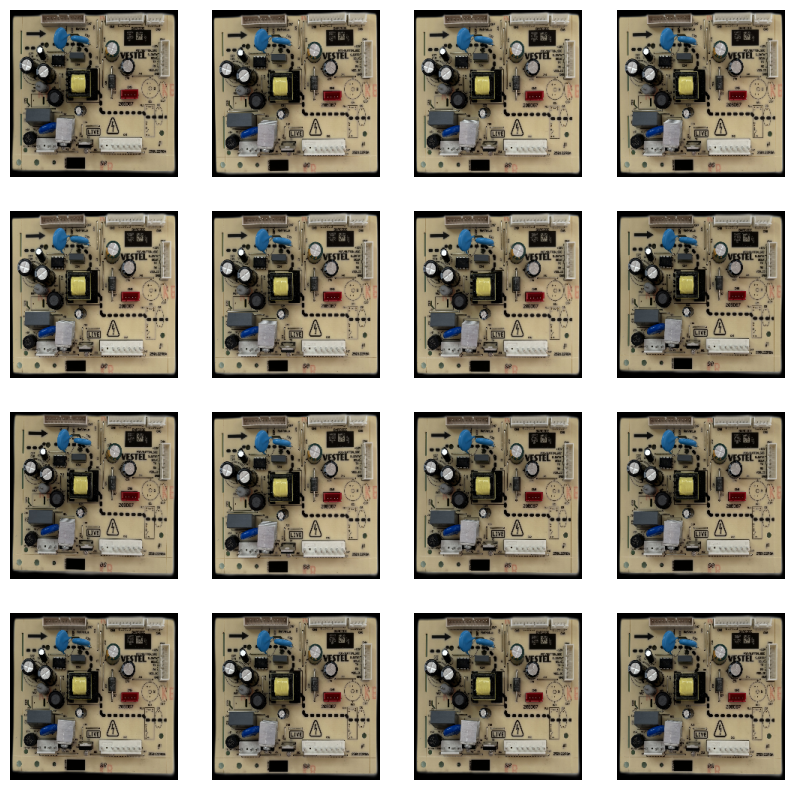

In [ ]:
vision.show_image_samples_from_batch(train_dataset)

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
# Pre-trained VGG16 Model
def create_encoder_model(input_encoder, latent_dim):
    n_leves_enc = 7
    n_dense = int(input_encoder[0]/(2**n_leves_enc))

    inputs = Input(shape=input_encoder, name='input_layer')

    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    # Unfreeze entire base model at initial
    vgg16.trainable = True

    # Freeze all layers except last few layers
    for layer in vgg16.layers[:-experiment['LAST_TRANIABLE_LAYERS']]:
        layer.trainable = False

    vgg16_out = vgg16(inputs)
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(vgg16_out)

    # Final Block
    flatten = Flatten()(global_avg_pooling)  # (None, 7, 7, 512) to (None, 25088)
    fc1 = Dense(units=(n_dense*n_dense*256))(flatten)

    # Batch normalization
    fc1 = BatchNormalization()(fc1)
    # Add activation function Leaky ReLU
    fc1 = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(fc1)

    # Latent variables
    output = Dense(latent_dim, name='mean')(fc1)
    output = LeakyReLU(alpha=experiment['LRELU_SLOPE'])(output)

    # Model
    model = Model(inputs, output, name="vgg16_encoder_model")

    model.summary()
    keras.utils.plot_model(model, "encoder_model.png")

    return model

In [ ]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'], latent_dim=200)

Model: "vgg16_encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_avg_pooling_layer (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                              

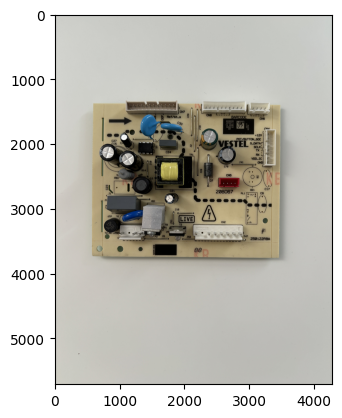

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

original_image = cv2.imread('/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/IMG_9106.JPG')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)

In [ ]:
ORIGINAL_IMG_DIR = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/IMG_9106.JPG'
REFERENCE_IMG_DIR = img_files[0]

Text(0.5, 1.0, 'Reference Image')

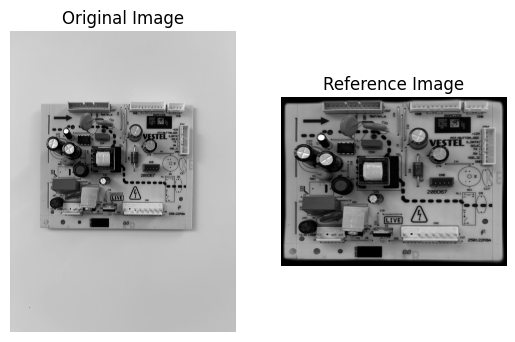

In [ ]:
original_image = cv2.imread(ORIGINAL_IMG_DIR, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(REFERENCE_IMG_DIR, cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(reference_image, cmap='gray')
plt.axis('off')
plt.title('Reference Image')

In [ ]:
FLANN_INDEX_KDTREE = 1

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reference_image, None)
kp2, des2 = sift.detectAndCompute(original_image, None)

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [ ]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [ ]:
MIN_MATCH_COUNT = 10

In [ ]:
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    matchesMask = mask.ravel().tolist()

    h,w = reference_image.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    cdd_box = [np.int32(dst)]

    img2 = cv2.polylines(original_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [ ]:
x1, x2 = np.min(cdd_box[0,:,:,0]), np.max(cdd_box[0,:,:,0])
y1, y2 = np.min(cdd_box[0,:,:,1]), np.max(cdd_box[0,:,:,1])

print(f"(x1, y1) = ({x1}, {y1}) ")
print(f"(x2, y2) = ({x2}, {y2}) ")

(x1, y1) = (520, 1255) 
(x2, y2) = (3549, 3854) 


In [ ]:
original_image = cv2.imread(ORIGINAL_IMG_DIR)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

In [ ]:
cropped_img = original_image[y1:y2,x1:x2,:]

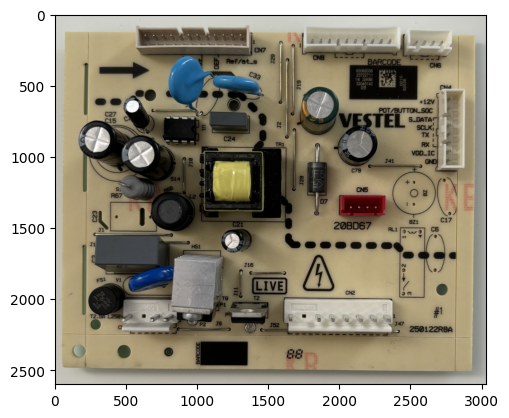

In [ ]:
plt.imshow(cropped_img)

In [ ]:
matchesMask_np = np.array(matchesMask)

In [ ]:
matchesMask_np.shape

(2240,)

https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html